In [25]:
import pandas as pd
import os

# Função para processar o CSV
def dividir_colunas_csv(file_path, output_file):
    try:
        # Ler o arquivo CSV
        df = pd.read_csv(file_path)

        # Função para limpar e converter valores
        def limpar_e_converter(valor):
            if isinstance(valor, str):
                valor = valor.replace(',', '.').replace(' ', '').strip()  # Trocar vírgula por ponto e remover espaços
            try:
                return float(valor) / 10  # Converter para float e dividir por 10
            except ValueError:
                return None  # Retorna None se a conversão falhar

        # Aplicar a função de limpeza e conversão nas colunas 2 e 3
        df.iloc[:, 1] = df.iloc[:, 1].apply(limpar_e_converter)  # Segunda coluna

        # Salvar o resultado em um novo arquivo
        df.to_csv(output_file, index=False)
        print(f"Arquivo processado e salvo como: {output_file}")
    except Exception as e:
        print(f"Erro ao processar o arquivo {file_path}: {e}")

# Nome do arquivo de entrada e saída
input_file = "A_FIXO_1.csv"
output_file = "A_FIXO_1_MELHORADO.csv"

# Chamar a função para processar o arquivo
dividir_colunas_csv(input_file, output_file)


Arquivo processado e salvo como: A_FIXO_1_MELHORADO.csv


## Testando método poly1d

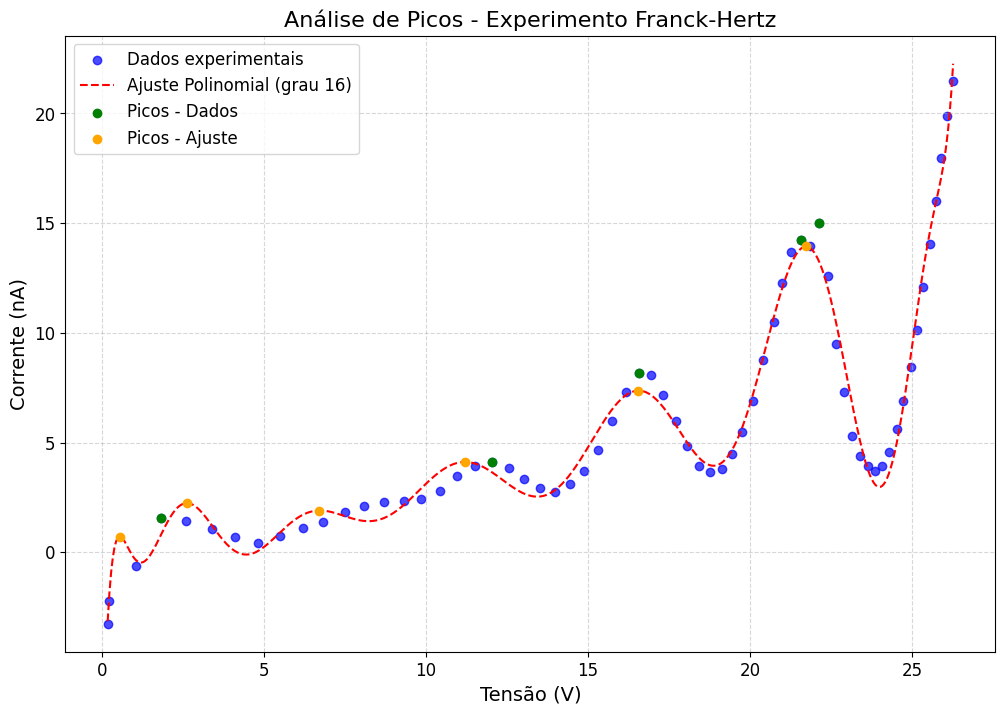

Picos nos dados experimentais (tensão, corrente):
Tensão: 1.83 V, Corrente: 1.58 nA
Tensão: 12.04 V, Corrente: 4.10 nA
Tensão: 16.57 V, Corrente: 8.19 nA
Tensão: 21.57 V, Corrente: 14.22 nA
Tensão: 22.14 V, Corrente: 15.00 nA

Picos na curva ajustada (tensão, corrente):
Tensão: 0.55 V, Corrente: 0.72 nA
Tensão: 2.64 V, Corrente: 2.24 nA
Tensão: 6.72 V, Corrente: 1.90 nA
Tensão: 11.21 V, Corrente: 4.11 nA
Tensão: 16.55 V, Corrente: 7.36 nA
Tensão: 21.72 V, Corrente: 13.94 nA


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Função para ajuste polinomial
def ajustar_polinomio(x, y, grau):
    coeficientes = np.polyfit(x, y, grau)
    polinomio = np.poly1d(coeficientes)
    return polinomio, coeficientes

# Carregar dados (substitua pelo seu arquivo CSV)
file_path = "A_FIXO_2.csv"
df = pd.read_csv(file_path, skiprows=1)  # Ignorar cabeçalhos nas primeiras linhas, se necessário

# Extrair colunas de tensão e corrente
try:
    # Limpeza e conversão das colunas
    tensao = df.iloc[:, 2].astype(str).str.replace(',', '.').str.strip()
    corrente = df.iloc[:, 1].astype(str).str.replace(',', '.').str.strip()
    
    # Converter para numérico
    tensao = pd.to_numeric(tensao, errors='coerce').dropna()
    corrente = pd.to_numeric(corrente, errors='coerce').dropna()
except IndexError:
    print("Erro: O arquivo não possui colunas suficientes. Verifique o formato dos dados.")
    exit()

# Verificar se as colunas não estão vazias
if tensao.empty or corrente.empty:
    print("Erro: As colunas de tensão ou corrente estão vazias. Verifique o arquivo de entrada.")
    exit()

# Ajuste polinomial
grau_polinomio = 16
polinomio, coeficientes = ajustar_polinomio(tensao, corrente, grau_polinomio)

# Gerar curva ajustada
x_fit = np.linspace(tensao.min(), tensao.max(), 500)
y_fit = polinomio(x_fit)

# Encontrar picos nos dados experimentais
picos_dados, _ = find_peaks(corrente, height=0)  # Altura mínima pode ser ajustada
picos_ajuste, _ = find_peaks(y_fit, height=0)

# Visualização dos resultados
plt.figure(figsize=(12, 8))

# Plot dos dados experimentais
plt.scatter(tensao, corrente, label='Dados experimentais', color='blue', alpha=0.7)

# Plot da curva ajustada
plt.plot(x_fit, y_fit, label=f'Ajuste Polinomial (grau {grau_polinomio})', color='red', linestyle='--')

# Marcar picos nos dados experimentais
if len(picos_dados) > 0:
    plt.scatter(tensao.iloc[picos_dados], corrente.iloc[picos_dados], color='green', label='Picos - Dados', zorder=5)

# Marcar picos na curva ajustada
if len(picos_ajuste) > 0:
    plt.scatter(x_fit[picos_ajuste], y_fit[picos_ajuste], color='orange', label='Picos - Ajuste', zorder=5)

# Configurações do gráfico
plt.title('Análise de Picos - Experimento Franck-Hertz', fontsize=16)
plt.xlabel('Tensão (V)', fontsize=14)
plt.ylabel('Corrente (nA)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Salvar o gráfico
plt.savefig("analise_picos.png", dpi=300)
plt.show()

# Exibir posições dos picos
print("Picos nos dados experimentais (tensão, corrente):")
if len(picos_dados) > 0:
    for i in picos_dados:
        print(f"Tensão: {tensao.iloc[i]:.2f} V, Corrente: {corrente.iloc[i]:.2f} nA")
else:
    print("Nenhum pico encontrado nos dados experimentais.")

print("\nPicos na curva ajustada (tensão, corrente):")
if len(picos_ajuste) > 0:
    for i in picos_ajuste:
        print(f"Tensão: {x_fit[i]:.2f} V, Corrente: {y_fit[i]:.2f} nA")
else:
    print("Nenhum pico encontrado na curva ajustada.")


## Testando Método do Spline Cubico

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline

# Carregar dados (substitua pelo seu arquivo CSV)
file_path = "R_FIXO_2.csv"
df = pd.read_csv(file_path, skiprows=1)

# Extrair colunas de tensão (tensao) e corrente (corrente)
try:
    tensao = df.iloc[:, 2].astype(str).str.replace(',', '.').str.strip()
    corrente = df.iloc[:, 1].astype(str).str.replace(',', '.').str.strip()

    # Converter para numérico
    tensao = pd.to_numeric(tensao, errors='coerce')
    corrente = pd.to_numeric(corrente, errors='coerce')

    # Remover NaNs
    valid_data = ~tensao.isna() & ~corrente.isna()
    tensao = tensao[valid_data]
    corrente = corrente[valid_data]

    # Excluir valores negativos de tensão
    positive_data = tensao >= 0
    tensao = tensao[positive_data]
    corrente = corrente[positive_data].reset_index(drop=True)

    # Remover duplicatas em tensão
    tensao, unique_indices = np.unique(tensao, return_index=True)
    corrente = corrente.iloc[unique_indices].reset_index(drop=True)
except IndexError:
    print("Erro: O arquivo não possui colunas suficientes. Verifique o formato dos dados.")
    exit()

# Verificar se as colunas não estão vazias
if len(tensao) < 2 or len(corrente) < 2:
    print("Erro: Dados insuficientes após limpeza. Verifique o arquivo de entrada.")
    exit()

# Interpolação spline cúbica
spline = CubicSpline(tensao, corrente)

# Gerar pontos para a curva ajustada
x_fit = np.linspace(tensao.min(), tensao.max(), 1000)
y_fit = spline(x_fit)

# Calcular distâncias entre pontos consecutivos nos dados experimentais
dist_pontos_dados = np.sqrt(np.diff(tensao)**2 + np.diff(corrente)**2)

# Calcular distâncias entre pontos consecutivos na curva ajustada
dist_pontos_ajuste = np.sqrt(np.diff(x_fit)**2 + np.diff(y_fit)**2)

# Detectar picos e vales nos dados experimentais
picos_dados, _ = find_peaks(corrente)  # Picos
vales_dados, _ = find_peaks(-corrente)  # Vales (sinal invertido)

# Detectar picos e vales na curva ajustada
picos_ajuste, _ = find_peaks(y_fit)  # Picos
vales_ajuste, _ = find_peaks(-y_fit)  # Vales (sinal invertido)

# Calcular distâncias entre picos e vales
dist_picos_vales_dados = [
    abs(tensao[peak] - tensao[valley]) for peak in picos_dados for valley in vales_dados
] if len(picos_dados) > 0 and len(vales_dados) > 0 else None

dist_picos_vales_ajuste = [
    abs(x_fit[peak] - x_fit[valley]) for peak in picos_ajuste for valley in vales_ajuste
] if len(picos_ajuste) > 0 and len(vales_ajuste) > 0 else None

# Calcular a média das distâncias
media_dist_picos_vales_dados = np.mean(dist_picos_vales_dados) if dist_picos_vales_dados else None
media_dist_picos_vales_ajuste = np.mean(dist_picos_vales_ajuste) if dist_picos_vales_ajuste else None

# Visualizar os resultados
plt.figure(figsize=(12, 8))

# Plot dos dados experimentais
plt.scatter(tensao, corrente, label='Dados experimentais', color='blue', alpha=0.7)

# Plot da curva ajustada (Spline Cúbica)
plt.plot(x_fit, y_fit, label='Ajuste por Spline Cúbica', color='red', linestyle='--')

# Destacar picos e vales nos dados experimentais
if len(picos_dados) > 0:
    plt.scatter(tensao[picos_dados], corrente[picos_dados], color='green', label='Picos - Dados', zorder=5)
if len(vales_dados) > 0:
    plt.scatter(tensao[vales_dados], corrente[vales_dados], color='orange', label='Vales - Dados', zorder=5)

# Destacar picos e vales na curva ajustada
if len(picos_ajuste) > 0:
    plt.scatter(x_fit[picos_ajuste], y_fit[picos_ajuste], color='purple', label='Picos - Ajuste', zorder=5)
if len(vales_ajuste) > 0:
    plt.scatter(x_fit[vales_ajuste], y_fit[vales_ajuste], color='cyan', label='Vales - Ajuste', zorder=5)

# Configurar o gráfico
plt.title('Análise de Picos e Vales', fontsize=16)
plt.xlabel('Tensão (V)', fontsize=14)
plt.ylabel('Corrente (nA)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Salvar e exibir o gráfico
plt.savefig("analise_picos_vales_com_distancias.png", dpi=300)
plt.show()

# Exibir os resultados
print("Distâncias entre pontos consecutivos nos Dados Experimentais:")
for dist in dist_pontos_dados:
    print(f"{dist:.2f}")

print("\nDistâncias entre pontos consecutivos na Curva Ajustada:")
for dist in dist_pontos_ajuste:
    print(f"{dist:.2f}")

print("\nPicos e Vales nos Dados Experimentais:")
if len(picos_dados) > 0:
    print("Picos:")
    for i in picos_dados:
        print(f"Tensão: {tensao[i]:.2f} V, Corrente: {corrente[i]:.2f} nA")
else:
    print("Nenhum pico encontrado nos dados experimentais.")

if len(vales_dados) > 0:
    print("\nVales:")
    for i in vales_dados:
        print(f"Tensão: {tensao[i]:.2f} V, Corrente: {corrente[i]:.2f} nA")
else:
    print("Nenhum vale encontrado nos dados experimentais.")

if dist_picos_vales_dados:
    print("\nDistâncias entre Picos e Vales nos Dados Experimentais:")
    for dist in dist_picos_vales_dados:
        print(f"{dist:.2f} V")
    print(f"Média das distâncias: {media_dist_picos_vales_dados:.2f} V")
else:
    print("Nenhuma distância calculada entre picos e vales nos dados experimentais.")

print("\nPicos e Vales na Curva Ajustada:")
if len(picos_ajuste) > 0:
    print("Picos:")
    for i in picos_ajuste:
        print(f"Tensão: {x_fit[i]:.2f} V, Corrente: {y_fit[i]:.2f} nA")
else:
    print("Nenhum pico encontrado na curva ajustada.")

if len(vales_ajuste) > 0:
    print("\nVales:")
    for i in vales_ajuste:
        print(f"Tensão: {x_fit[i]:.2f} V, Corrente: {y_fit[i]:.2f} nA")
else:
    print("Nenhum vale encontrado na curva ajustada.")

if dist_picos_vales_ajuste:
    print("\nDistâncias entre Picos e Vales na Curva Ajustada:")
    for dist in dist_picos_vales_ajuste:
        print(f"{dist:.2f} V")
    print(f"Média das distâncias: {media_dist_picos_vales_ajuste:.2f} V")
else:
    print("Nenhuma distância calculada entre picos e vales na curva ajustada.")


FileNotFoundError: [Errno 2] No such file or directory: 'R_FIXO_2.csv'

## Generalizando para todos os arquivos da pasta

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline

# Função para processar um arquivo CSV
def processar_csv(file_path):
    print(f"\nProcessando arquivo: {file_path}")
    df = pd.read_csv(file_path, skiprows=1)

    # Extrair colunas de tensão e corrente
    try:
        tensao = df.iloc[:, 2].astype(str).str.replace(',', '.').str.strip()
        corrente = df.iloc[:, 1].astype(str).str.replace(',', '.').str.strip()
        tensao = pd.to_numeric(tensao, errors='coerce')
        corrente = pd.to_numeric(corrente, errors='coerce')
        valid_data = ~tensao.isna() & ~corrente.isna()
        tensao = tensao[valid_data]
        corrente = corrente[valid_data]

        # Excluir valores negativos de tensão
        positive_data = tensao >= 0
        tensao = tensao[positive_data]
        corrente = corrente[positive_data].reset_index(drop=True)

        # Remover duplicatas em tensão
        tensao, unique_indices = np.unique(tensao, return_index=True)
        corrente = corrente.iloc[unique_indices].reset_index(drop=True)
    except IndexError:
        print(f"Erro: O arquivo {file_path} não possui colunas suficientes.")
        return

    if len(tensao) < 2 or len(corrente) < 2:
        print(f"Erro: Dados insuficientes no arquivo {file_path}.")
        return

    # Interpolação spline cúbica
    spline = CubicSpline(tensao, corrente)
    x_fit = np.linspace(tensao.min(), tensao.max(), 1000)
    y_fit = spline(x_fit)

    # Encontrar picos e vales
    picos_dados, _ = find_peaks(corrente)
    vales_dados, _ = find_peaks(-corrente)
    picos_ajuste, _ = find_peaks(y_fit)
    vales_ajuste, _ = find_peaks(-y_fit)

    # Calcular distâncias entre picos e vales dos dados (somente do pico para o vale)
    dist_picos_vales = []
    if len(picos_dados) > 0 and len(vales_dados) > 0:
        for pico in picos_dados:
            tensao_pico = tensao[pico]
            vales_apos_pico = vales_dados[vales_dados > pico]  # Apenas vales após o pico
            if len(vales_apos_pico) > 0:
                tensao_vale = tensao[vales_apos_pico[0]]
                distancia = tensao_vale - tensao_pico
                dist_picos_vales.append(distancia)

    # Calcular distâncias entre picos consecutivos e vales consecutivos
    dist_picos_consecutivos = np.diff(tensao[picos_dados]) if len(picos_dados) > 1 else []
    dist_vales_consecutivos = np.diff(tensao[vales_dados]) if len(vales_dados) > 1 else []
    media_dist_picos_consecutivos = np.nanmean(dist_picos_consecutivos) if len(dist_picos_consecutivos) > 0 else np.nan
    media_dist_vales_consecutivos = np.nanmean(dist_vales_consecutivos) if len(dist_vales_consecutivos) > 0 else np.nan

    # Salvar resultados em um arquivo CSV
    output_csv = os.path.splitext(file_path)[0] + "_results.csv"
    resultados = {
        "Pico (Tensão - Dados)": tensao[picos_dados] if len(picos_dados) > 0 else np.nan,
        "Pico (Corrente - Dados)": corrente[picos_dados] if len(picos_dados) > 0 else np.nan,
        "Vale (Tensão - Dados)": tensao[vales_dados] if len(vales_dados) > 0 else np.nan,
        "Vale (Corrente - Dados)": corrente[vales_dados] if len(vales_dados) > 0 else np.nan,
        "Distância Picos-Vales (Dados)": dist_picos_vales,
        "Distância Picos Consecutivos (V)": dist_picos_consecutivos,
        "Distância Vales Consecutivos (V)": dist_vales_consecutivos,
        "Média Distância Picos Consecutivos (V)": [media_dist_picos_consecutivos],
        "Média Distância Vales Consecutivos (V)": [media_dist_vales_consecutivos],
    }
    resultados_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in resultados.items()]))
    resultados_df.to_csv(output_csv, index=False)
    print(f"Resultados salvos em: {output_csv}")

    # Plotar os resultados
    plt.figure(figsize=(12, 8))
    plt.scatter(tensao, corrente, label='Dados experimentais', color='blue', alpha=0.7)
    plt.plot(x_fit, y_fit, label='Ajuste por Spline Cúbica', color='red', linestyle='--')

    if len(picos_dados) > 0:
        plt.scatter(tensao[picos_dados], corrente[picos_dados], color='green', label='Picos - Dados', zorder=5)
    if len(vales_dados) > 0:
        plt.scatter(tensao[vales_dados], corrente[vales_dados], color='orange', label='Vales - Dados', zorder=5)
    if len(picos_ajuste) > 0:
        plt.scatter(x_fit[picos_ajuste], y_fit[picos_ajuste], color='purple', label='Picos - Ajuste', zorder=5)
    if len(vales_ajuste) > 0:
        plt.scatter(x_fit[vales_ajuste], y_fit[vales_ajuste], color='cyan', label='Vales - Ajuste', zorder=5)

    plt.title(f'Análise de Picos e Vales - {os.path.basename(file_path)}', fontsize=16)
    plt.xlabel('Tensão (V)', fontsize=14)
    plt.ylabel('Corrente (nA)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Salvar gráfico
    output_image = os.path.splitext(file_path)[0] + "_spline_analysis.png"
    plt.savefig(output_image, dpi=300)
    plt.close()
    print(f"Gráfico salvo em: {output_image}")

# Processar todos os arquivos CSV na pasta atual
current_directory = os.getcwd()
csv_files = [f for f in os.listdir(current_directory) if f.endswith('.csv')]

if not csv_files:
    print("Nenhum arquivo CSV encontrado na pasta atual.")
else:
    for csv_file in csv_files:
        processar_csv(os.path.join(current_directory, csv_file))



Processando arquivo: c:\Users\Filipe\Desktop\UFBA\franck_hertz\A_FIXO_1.csv
Resultados salvos em: c:\Users\Filipe\Desktop\UFBA\franck_hertz\A_FIXO_1_results.csv
Gráfico salvo em: c:\Users\Filipe\Desktop\UFBA\franck_hertz\A_FIXO_1_spline_analysis.png

Processando arquivo: c:\Users\Filipe\Desktop\UFBA\franck_hertz\A_FIXO_1_MELHORADO.csv
Resultados salvos em: c:\Users\Filipe\Desktop\UFBA\franck_hertz\A_FIXO_1_MELHORADO_results.csv
Gráfico salvo em: c:\Users\Filipe\Desktop\UFBA\franck_hertz\A_FIXO_1_MELHORADO_spline_analysis.png

Processando arquivo: c:\Users\Filipe\Desktop\UFBA\franck_hertz\A_FIXO_1_results.csv
Erro: Dados insuficientes no arquivo c:\Users\Filipe\Desktop\UFBA\franck_hertz\A_FIXO_1_results.csv.

Processando arquivo: c:\Users\Filipe\Desktop\UFBA\franck_hertz\A_FIXO_2_MELHORADO.csv
Resultados salvos em: c:\Users\Filipe\Desktop\UFBA\franck_hertz\A_FIXO_2_MELHORADO_results.csv
Gráfico salvo em: c:\Users\Filipe\Desktop\UFBA\franck_hertz\A_FIXO_2_MELHORADO_spline_analysis.png

